**Zadanie 5**
Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem Taxi. Problem dostępny jest w pakiecie gym.

Punktacja (max 7 pkt):

* Implementacja algorytmu Q-learning. [3 pkt]
* Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
* Jakość kodu [1 pkt]
* Wnioski [1 pkt]

In [1]:
import numpy as np
!pip install gymnasium
import gymnasium as gym
import pygame
import matplotlib.pylab as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.5 MB/s eta 0:00:00


In [2]:
class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""
    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

        self.q_table = np.zeros((observation_space, action_space))
        self.rewards = [0]

    def __call__(self, state: np.ndarray, action: np.ndarray) -> float:
        """Return Q-value of given state and action."""
        return self.q_table[state, action]

    def update(self, state: int, action: int, reward: float, next_state: int) -> None:
        """Update Q-value of given state and action using the Q-learning update rule."""
        new_reward = (1 - self.learning_rate) * self.q_table[state, action] + self.learning_rate * \
                (reward + self.gamma * max(self.q_table[next_state, :]))
        self.q_table[state, action] = new_reward

    def get_best_action(self, state: int, is_training=True) -> int:
        """Return action that maximizes Q-value for a given state."""
        if np.random.rand() < self.epsilon and is_training:
            return np.random.choice(self.action_space)
        else:
            return np.argmax(self.q_table[state, :])

    def trace_rewards(self) -> None:
        self.rewards.append(self.q_table.sum())

    def get_rewards(self) -> list[float]:
        return self.rewards

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        return f"QLearningSolver:\n-observation_space={self.observation_space},\n-action_space={self.action_space},\n-learning_rate={self.learning_rate},\n-gamma={self.gamma},\n-epsilon={self.epsilon})"

    def __str__(self):
        return self.__repr__()

# TRENING I WIZUALIZACJA

Funkcje użyte do treningu i wizualizacji

In [3]:
def train_q_learning_solver(environment: gym.Env, q_solver: QLearningSolver, num_episodes: int = 2000) -> None:
    for _ in range(num_episodes):
        curr_state, info = environment.reset()
        terminal = False
        truncated = False
        while not terminal and not truncated:
            action = q_solver.get_best_action(curr_state)
            next_state, reward, terminal, truncated, info = environment.step(action)
            q_solver.update(curr_state, action, reward, next_state)
            curr_state = next_state
        q_solver.trace_rewards()


In [4]:
def visualize_taxi_environment(q_solver: QLearningSolver) -> None:
    environment = gym.make('Taxi-v3', render_mode="human")
    curr_state, info = environment.reset()
    terminal = False
    truncated = False
    while not terminal and not truncated:
        environment.render()
        action = q_solver.get_best_action(curr_state, is_training=False)
        next_state, reward, terminal, truncated, info = environment.step(action)
        curr_state = next_state
        pygame.time.delay(100)
    environment.render()
    environment.close()

# EKSPERYMENTY


Funckje użyte do testowania solvera

In [32]:
def test_hiperparameter(
        param_name: str,
        param_values: np.ndarray,
        tries: int = 50,
        episodes: int = 2000,
        additional_param_name: str = None,
        additional_param_value: float = None,
        max_episode_steps: int = 50) -> dict[float, tuple[int, list[float]]]:

    results = dict()
    for param_value in param_values:
        kwargs = {param_name: param_value}
        if additional_param_name is not None:
            kwargs[additional_param_name] = additional_param_value
        solver = QLearningSolver(500, 6, **kwargs)
        taxi_env = gym.make('Taxi-v3', max_episode_steps=max_episode_steps)
        train_q_learning_solver(taxi_env, solver, episodes)
        results[param_value] = (get_amount_of_wins(solver, taxi_env, tries), solver.get_rewards())
    return results

In [6]:
def get_amount_of_wins(q_solver: QLearningSolver, environment: gym.Env, tries: int) -> int:
    wins = 0
    for _ in range(tries):
        curr_state, info = environment.reset()
        terminal = False
        truncated = False
        while not terminal and not truncated:
            action = q_solver.get_best_action(curr_state, is_training=False)
            next_state, reward, terminal, truncated, info = environment.step(action)
            curr_state = next_state
            if terminal and not truncated:
                wins += 1
    return wins

# Wpływ parametru Learning Rate

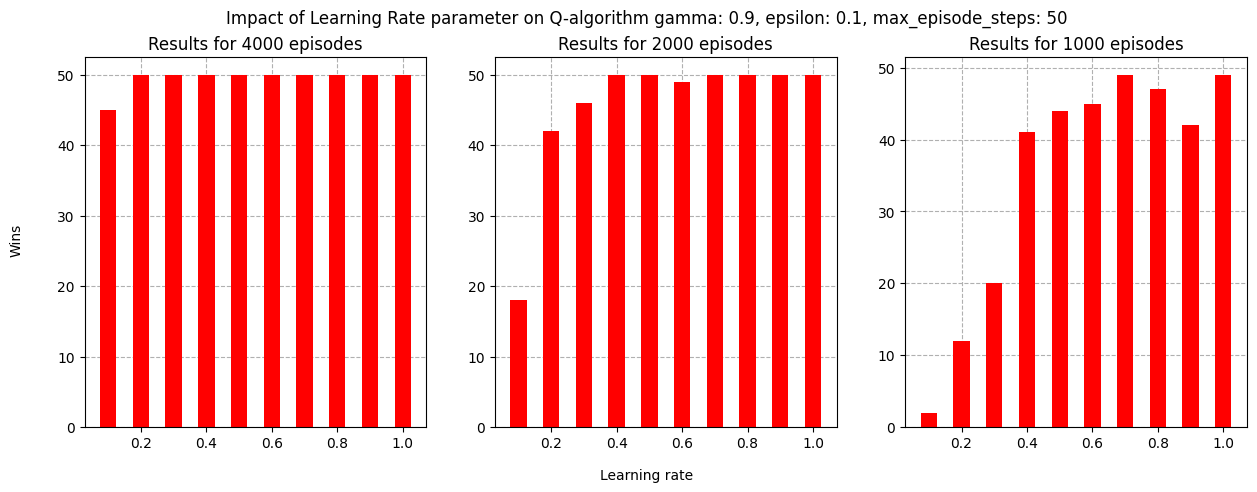

In [7]:
param_values = np.arange(0.1, 1.01, 0.1)
episodes = [4000, 2000, 1000]
tries = 50
ticks = np.arange(0, tries+0.01, 10)

fig, axis = plt.subplots(1, 3)

for ax, episode_n in zip(axis.flat, episodes):
  results = test_hiperparameter(param_name="learning_rate", param_values=param_values, episodes=episode_n)
  keys = results.keys()
  wins = [value[0] for value in results.values()]
  ax.bar(keys, wins, width = 0.05, color='r')
  ax.set_yticks(ticks=ticks)
  ax.set_title(f"Results for {episode_n} episodes")
  ax.grid(True, linestyle='dashed')
  ax.set_axisbelow(True)

fig.text(0.5, 0.01, 'Learning rate', ha='center', va='center')
fig.text(0.08, 0.5, 'Wins', ha='center', va='center', rotation='vertical')
fig.suptitle('Impact of Learning Rate parameter on Q-algorithm gamma: 0.9, epsilon: 0.1, max_episode_steps: 50')
fig.set_figwidth(15)

fig.show()

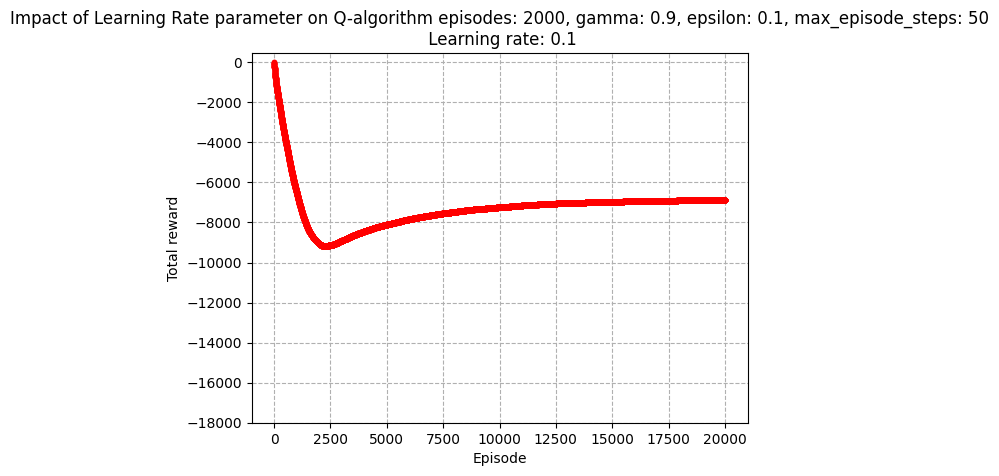

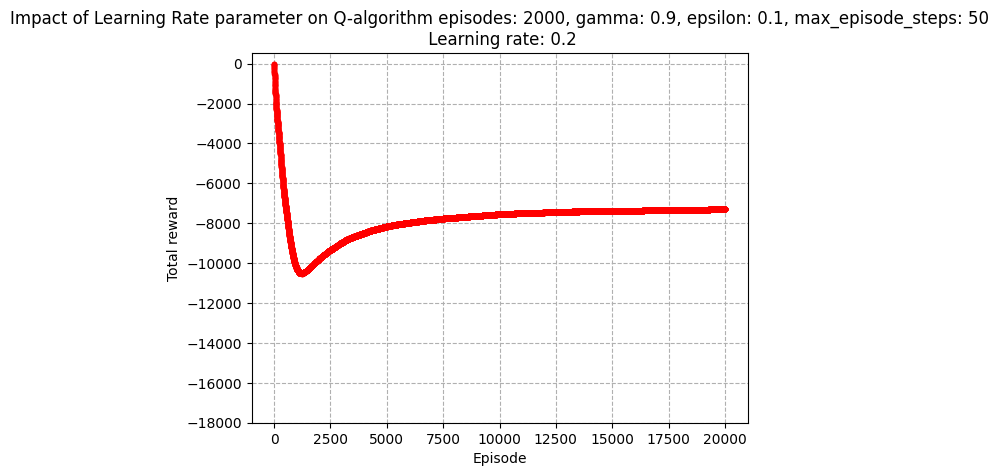

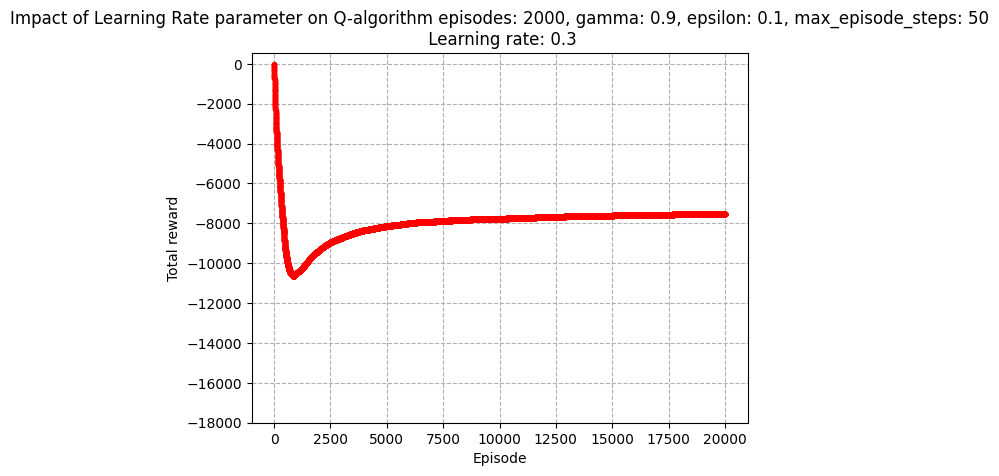

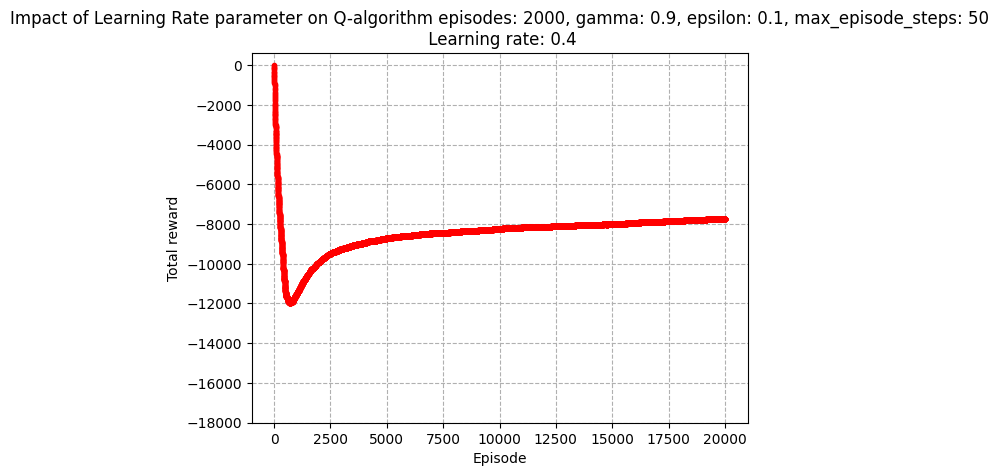

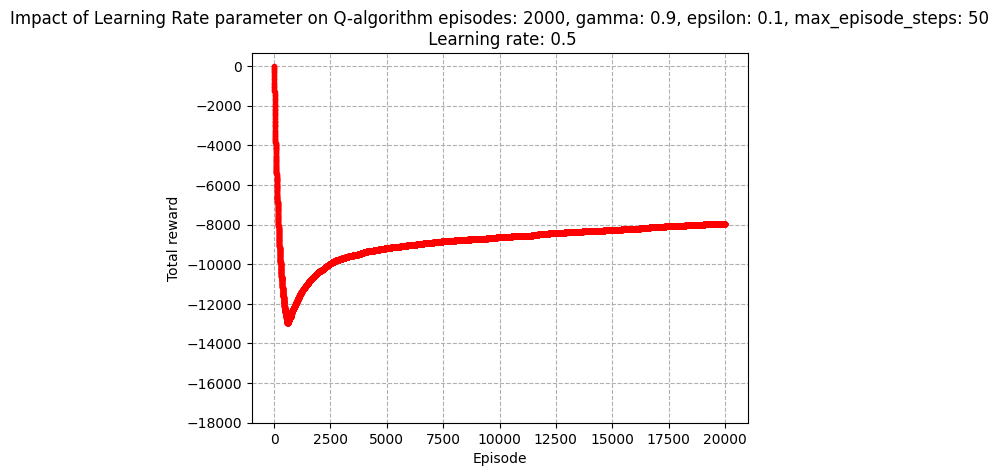

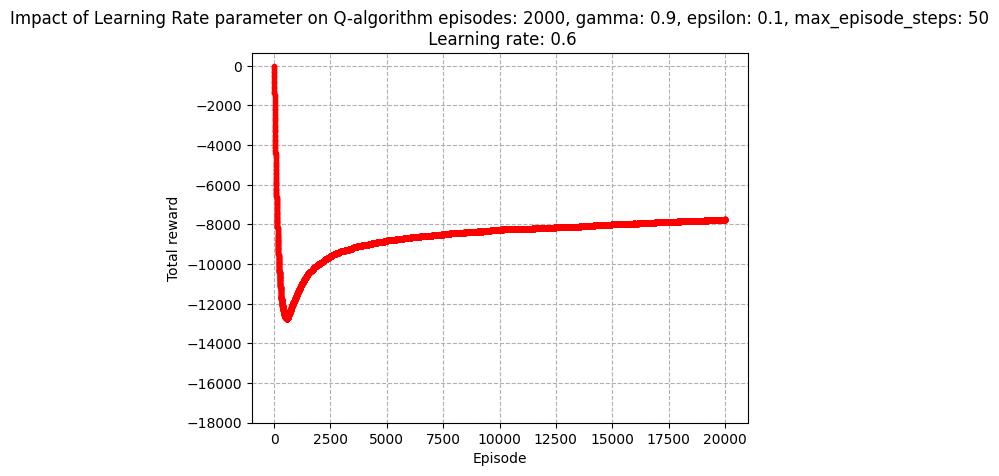

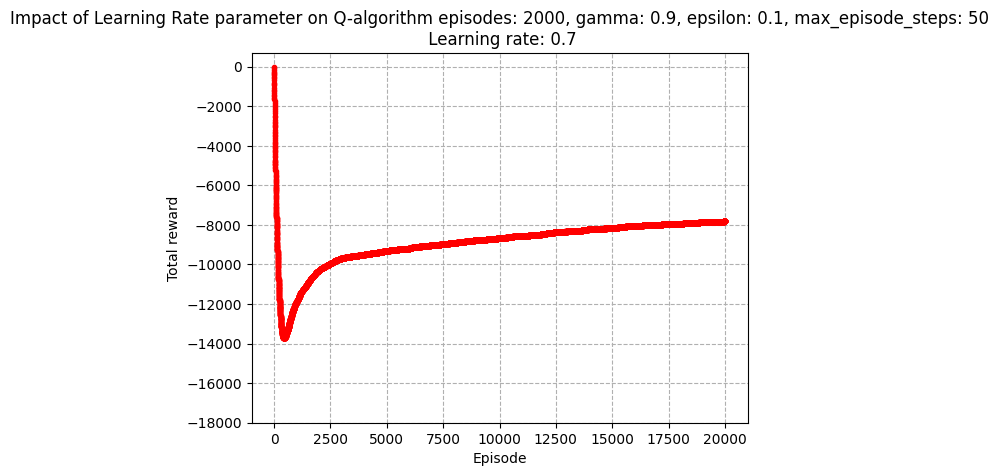

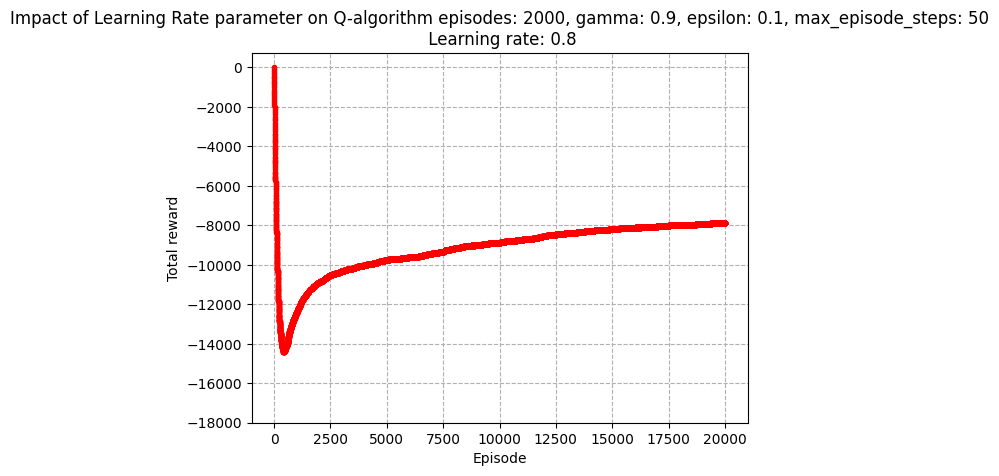

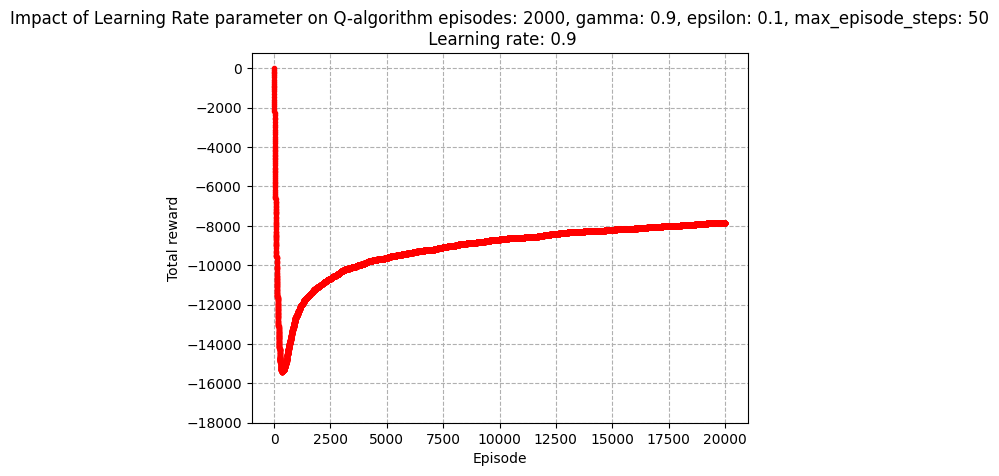

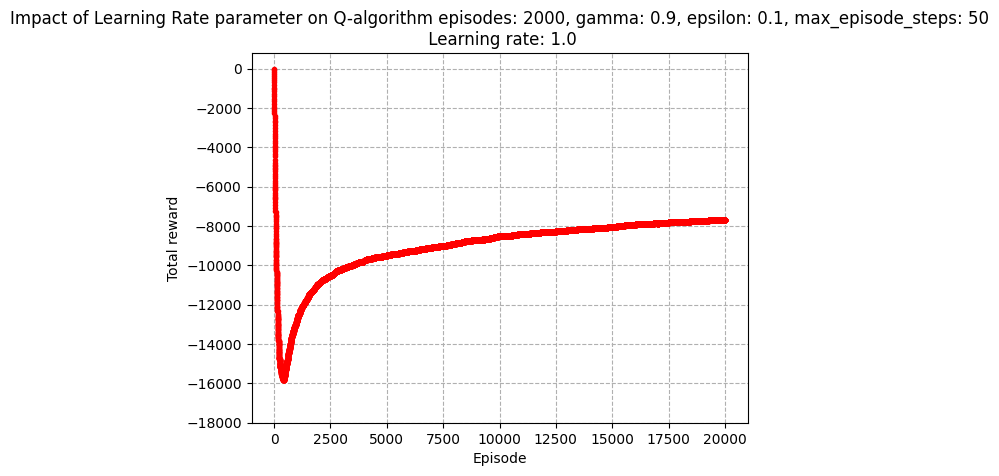

In [52]:
param_values = np.arange(0.1, 1.01, 0.1)
results = test_hiperparameter(param_name="learning_rate", param_values=param_values, episodes = 20000)
keys = results.keys()
trace_rewards = [value[1] for value in results.values()]
for param_value, trace in zip(param_values, trace_rewards):
    plt.plot(range(len(trace)), trace, marker='.', color='r')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.yticks(ticks=np.arange(0, -18000.01, -2000))
    plt.grid(True, linestyle='dashed', zorder=2.5)
    plt.title(f'Impact of Learning Rate parameter on Q-algorithm episodes: 2000, gamma: 0.9, epsilon: 0.1, max_episode_steps: 50\n Learning rate: {round(param_value, 1)}')
    plt.show()

- Learning rate odpowiada za to w jakim stopniu nowa informacja informacje zastępują stare. Im niższy learning rate tym wolniej uczy się agent
- Im mniejsza liczba epizodów przy uczeniu tym większe znaczenie ma współczynnik learning rate

# Wpływ parametru Gamma


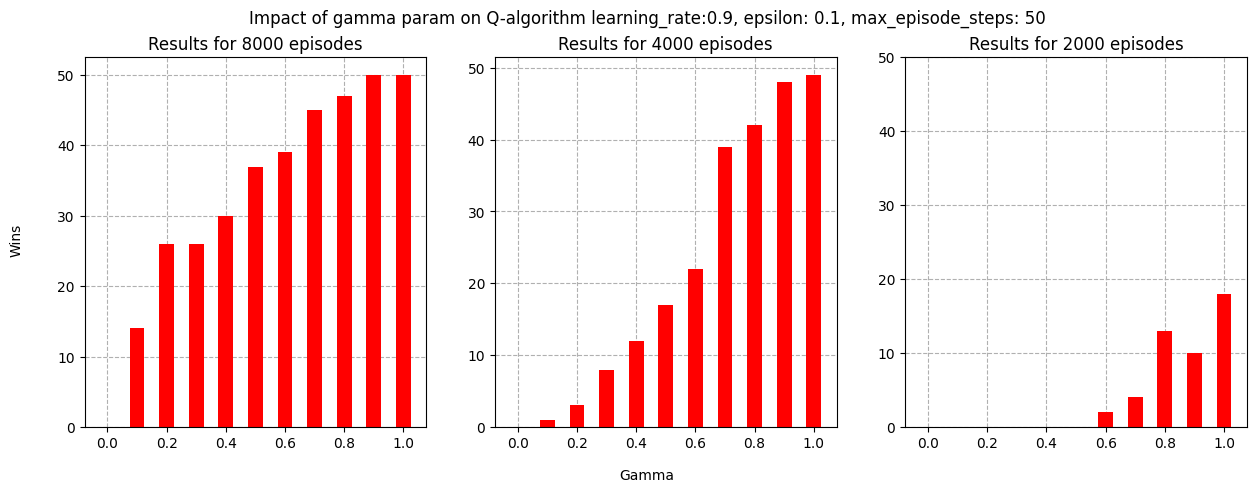

In [27]:
param_values = np.arange(0, 1.01, 0.1)
episodes = [8000, 4000, 2000]
tries = 50
ticks = np.arange(0, tries+0.01, 10)

fig, axis = plt.subplots(1, 3)

for ax, episode_n in zip(axis.flat, episodes):
  results = test_hiperparameter(param_name="gamma", param_values=param_values, episodes=episode_n, tries=tries)
  keys = results.keys()
  wins = [value[0] for value in results.values()]
  ax.bar(keys, wins, width = 0.05, color='r')
  ax.set_yticks(ticks=ticks)
  ax.set_title(f"Results for {episode_n} episodes")
  ax.grid(True, linestyle='dashed')
  ax.set_axisbelow(True)

fig.text(0.5, 0.01, 'Gamma', ha='center', va='center')
fig.text(0.08, 0.5, 'Wins', ha='center', va='center', rotation='vertical')
fig.suptitle('Impact of gamma param on Q-algorithm learning_rate:0.9, epsilon: 0.1, max_episode_steps: 50')
fig.set_figwidth(15)

fig.show()

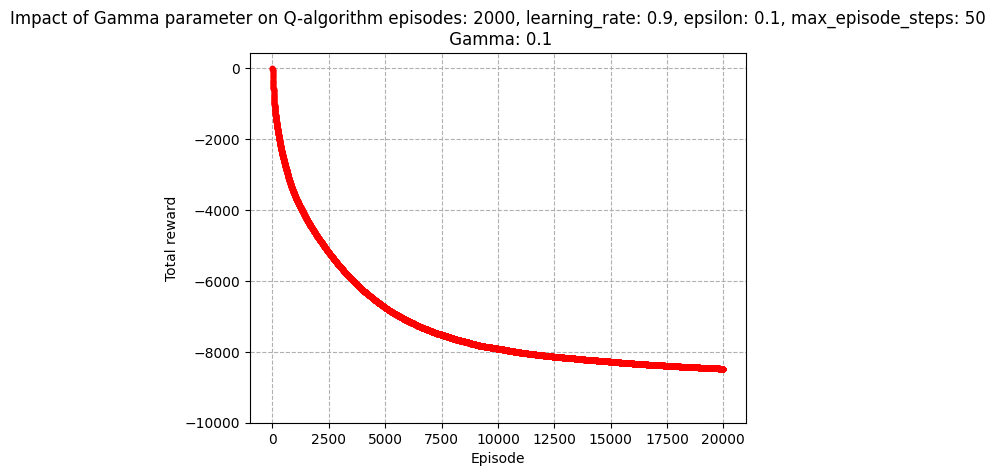

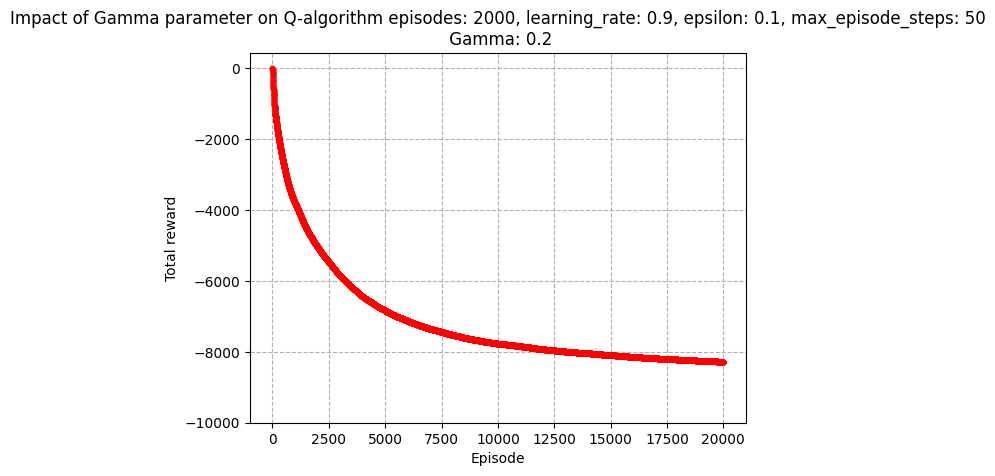

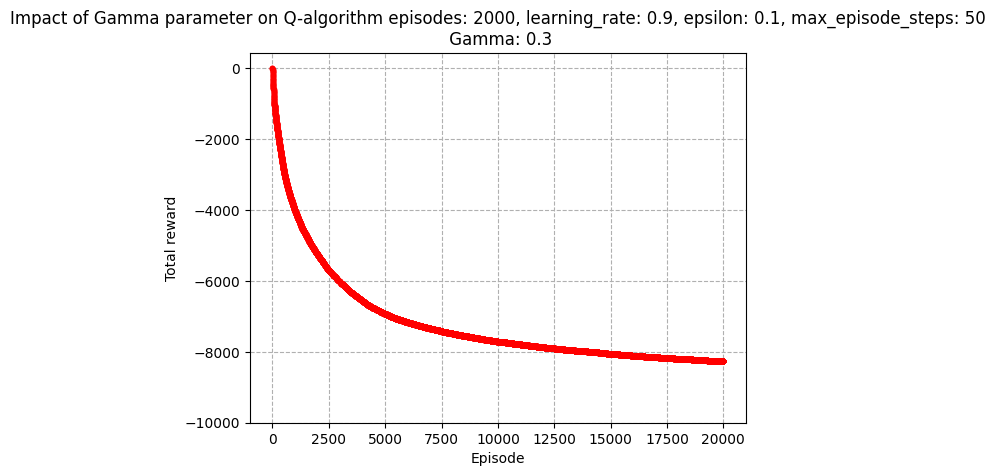

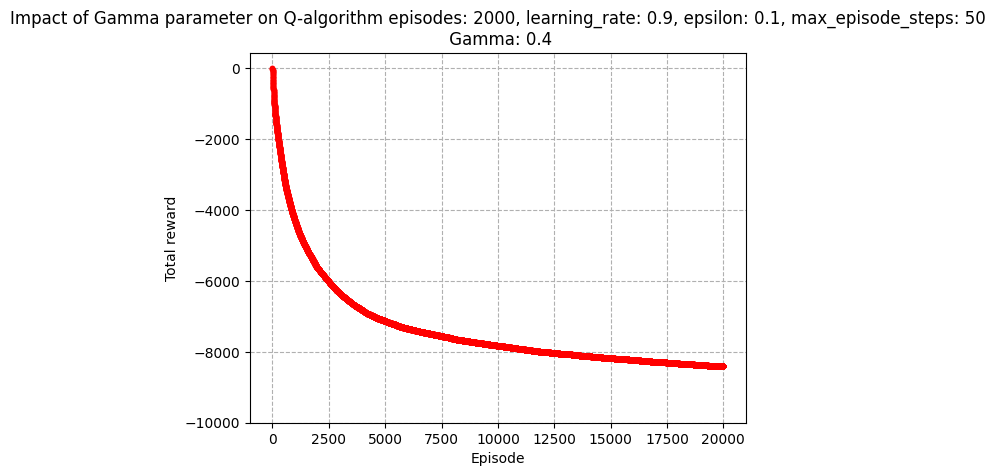

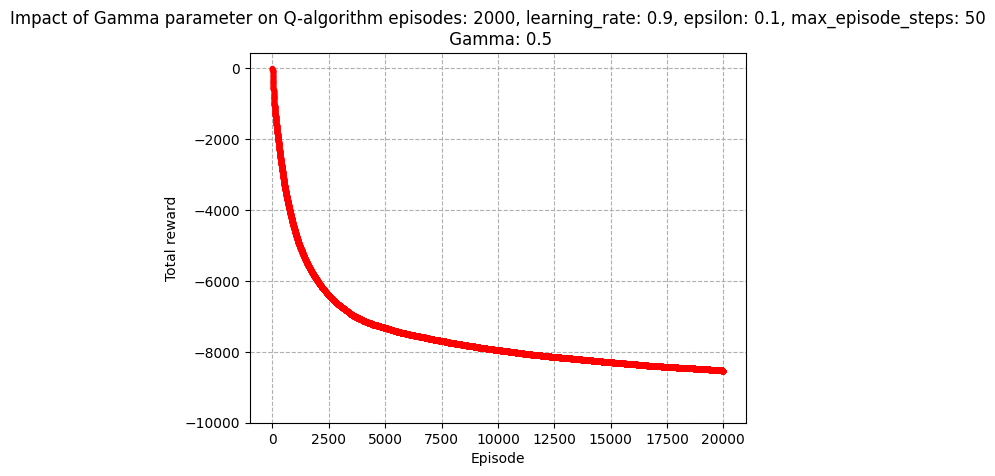

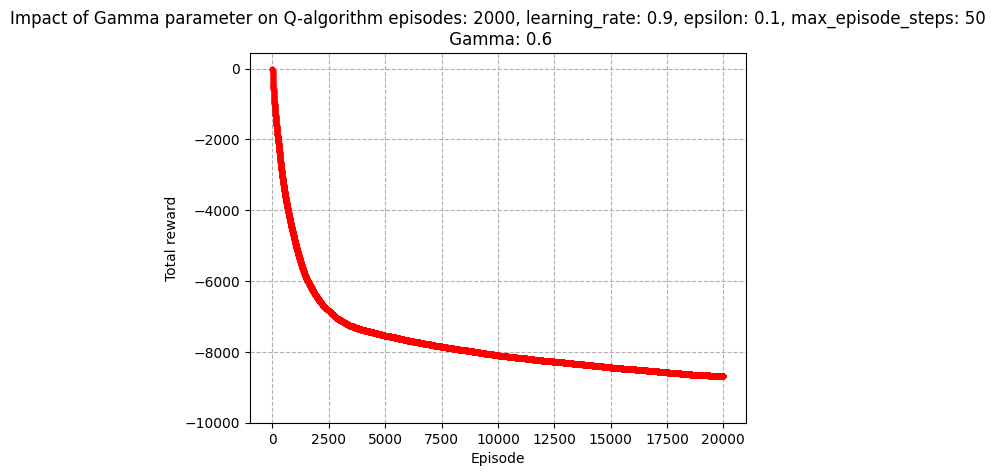

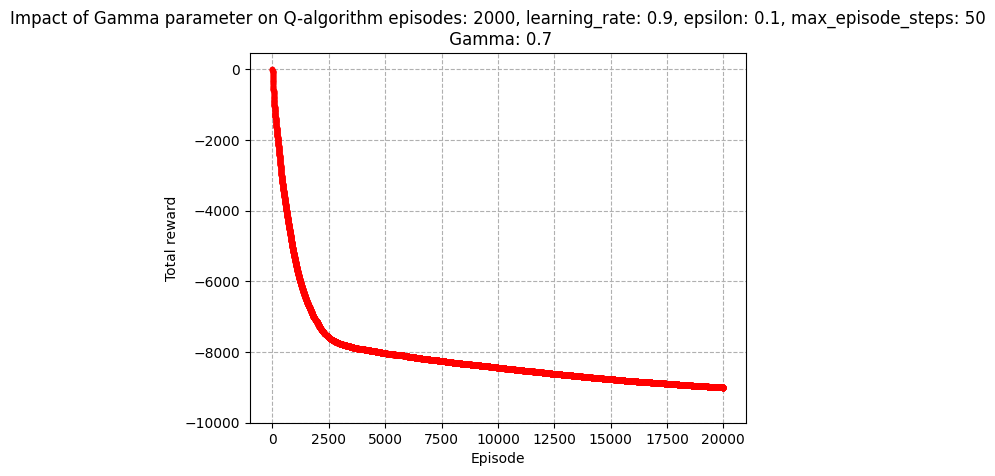

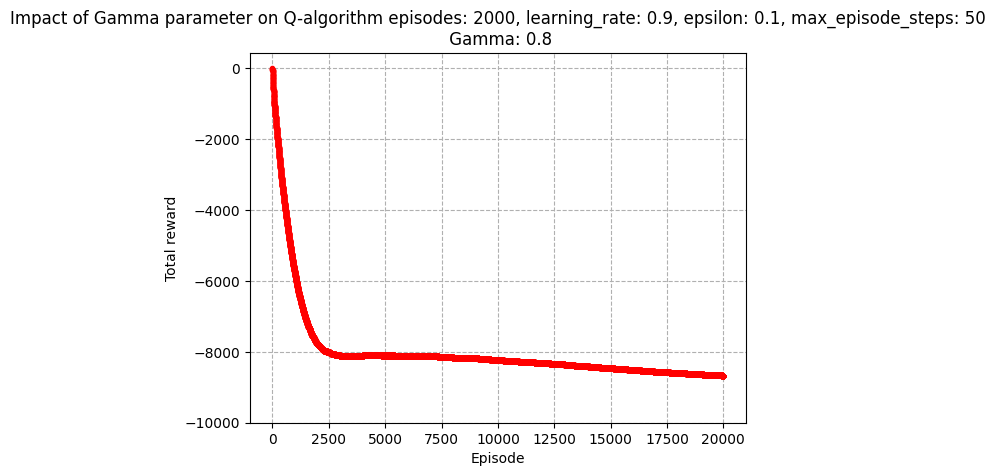

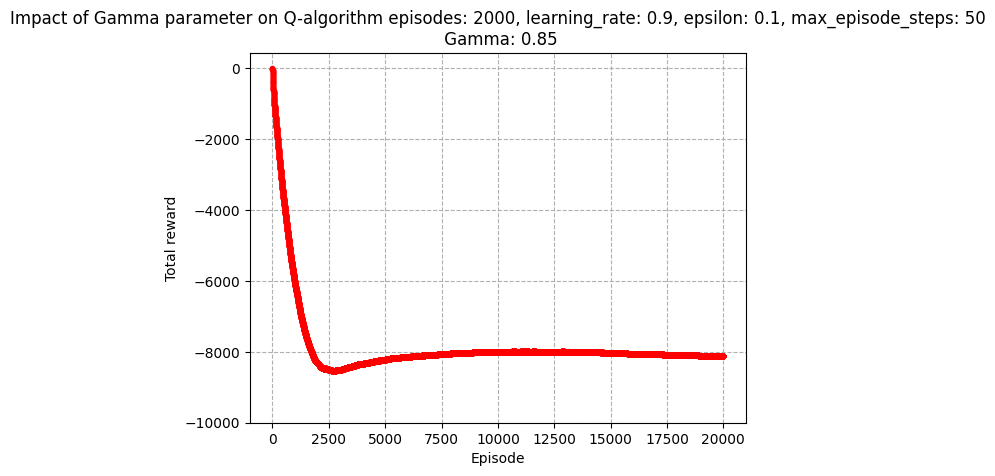

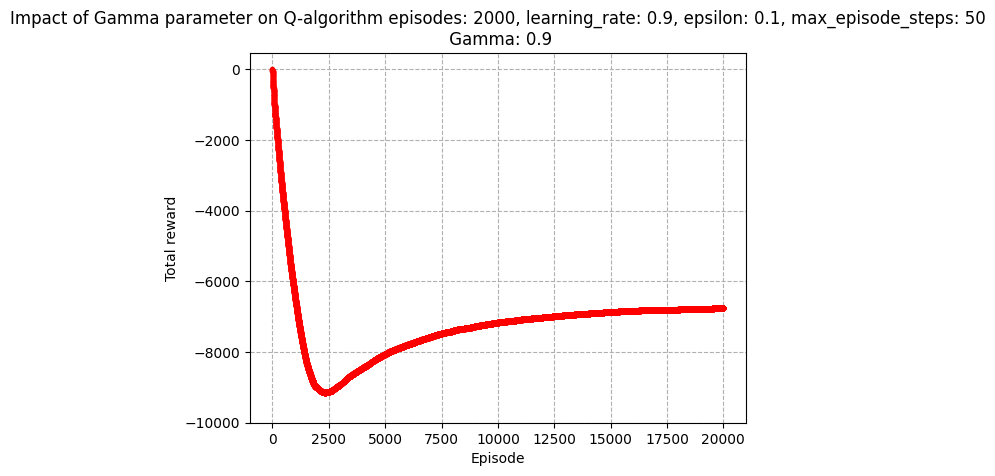

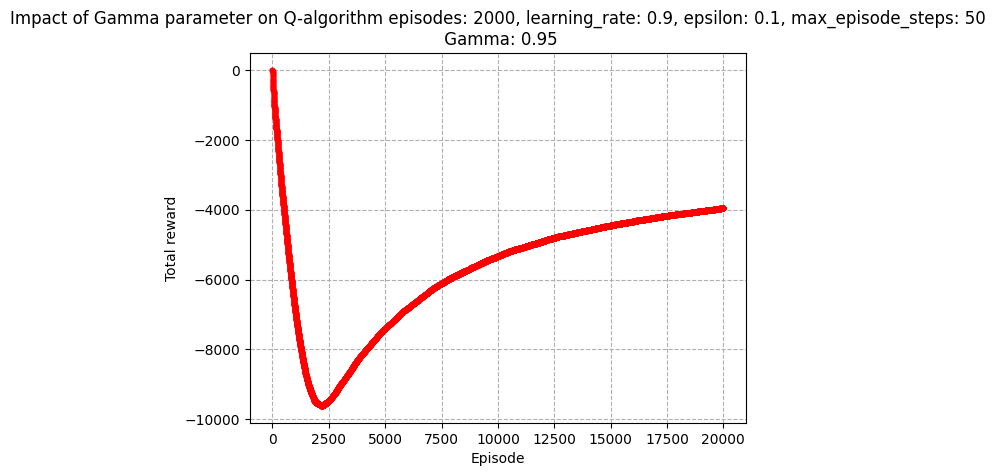

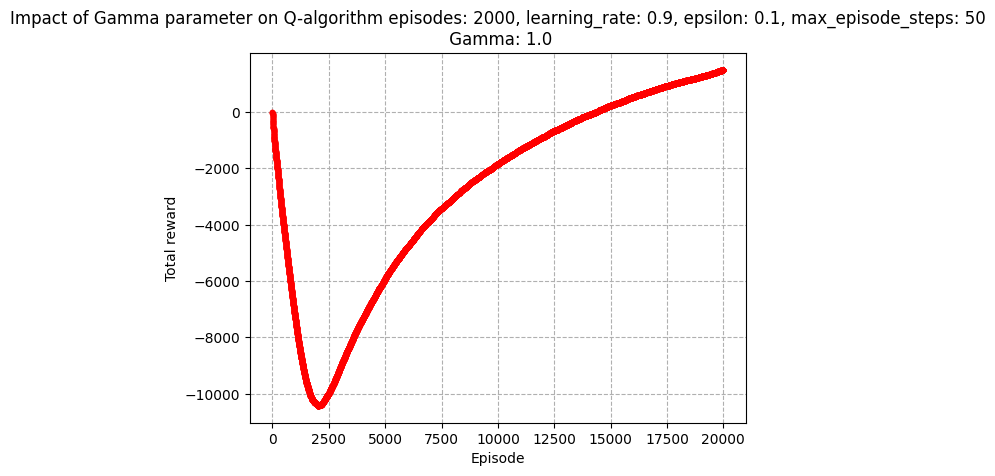

In [51]:
param_values = np.concatenate((np.arange(0.1, 0.8, 0.1), np.arange(0.8, 1.01, 0.05)))
results = test_hiperparameter(param_name="gamma", param_values=param_values, episodes = 20000)
keys = results.keys()
trace_rewards = [value[1] for value in results.values()]
for param_value, trace in zip(param_values, trace_rewards):
    plt.plot(range(len(trace)), trace, marker='.', color='r')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.yticks(ticks=np.arange(0, -10000.01, -2000))
    plt.grid(True, linestyle='dashed', zorder=2.5)
    plt.title(f'Impact of Gamma parameter on Q-algorithm episodes: 2000, learning_rate: 0.9, epsilon: 0.1, max_episode_steps: 50\n Gamma: {round(param_value, 2)}')
    plt.show()

- Współczynnik gamma określa znaczenie przyszłej nagrody dla decyzji agenta (współczynnik dyskontowania).
Jeśli gamma jest bliższa 0, agent będzie priorytezował natychmiastowe nagrody. Przy wartościach bliższysz 1, agent będzie bardziej brał pod uwagę przyszłe nagrody.
- Mniejsze wartości gammy dają gorsze wyniki - agent skupia się na natychmiastowych nagrodach - zwiększenie liczby epizodów uczących rozwiązuje problem

# Wpływ parametru Epsilon

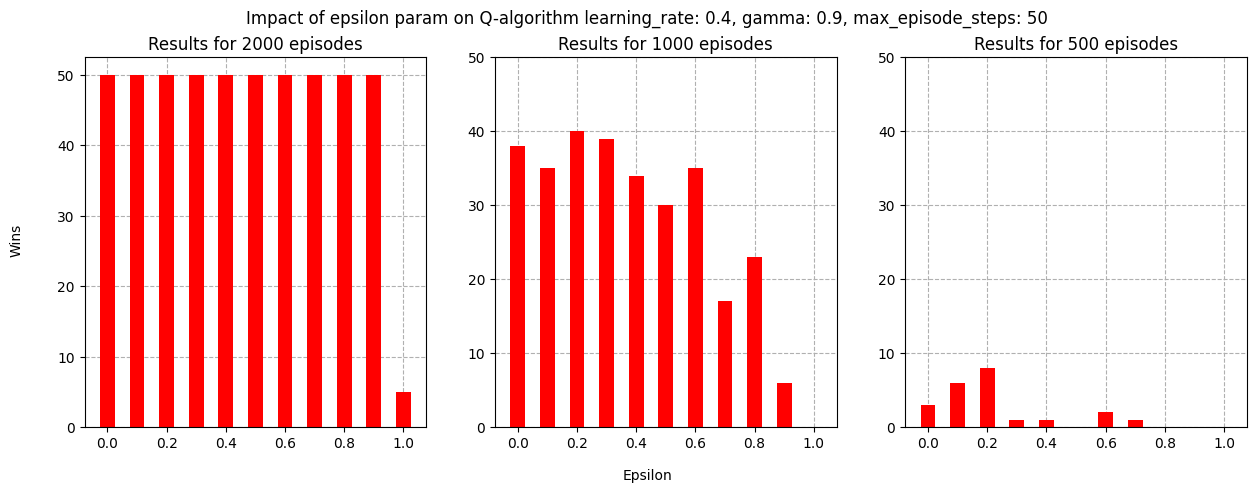

In [39]:
param_values = np.arange(0, 1.01, 0.1)
episodes = [2000, 1000, 500]
tries = 50
ticks = np.arange(0, tries+0.01, 10)

fig, axis = plt.subplots(1, 3)

for ax, episode_n in zip(axis.flat, episodes):
  results = test_hiperparameter(param_name="epsilon", param_values=param_values, episodes=episode_n, tries=tries, additional_param_name='learning_rate', additional_param_value=0.4)
  keys = results.keys()
  wins = [value[0] for value in results.values()]
  ax.bar(keys, wins, width = 0.05, color='r')
  ax.set_yticks(ticks=ticks)
  ax.set_title(f"Results for {episode_n} episodes")
  ax.grid(True, linestyle='dashed')
  ax.set_axisbelow(True)

fig.text(0.5, 0.01, 'Epsilon', ha='center', va='center')
fig.text(0.08, 0.5, 'Wins', ha='center', va='center', rotation='vertical')
fig.suptitle('Impact of epsilon param on Q-algorithm learning_rate: 0.4, gamma: 0.9, max_episode_steps: 50')
fig.set_figwidth(15)

fig.show()

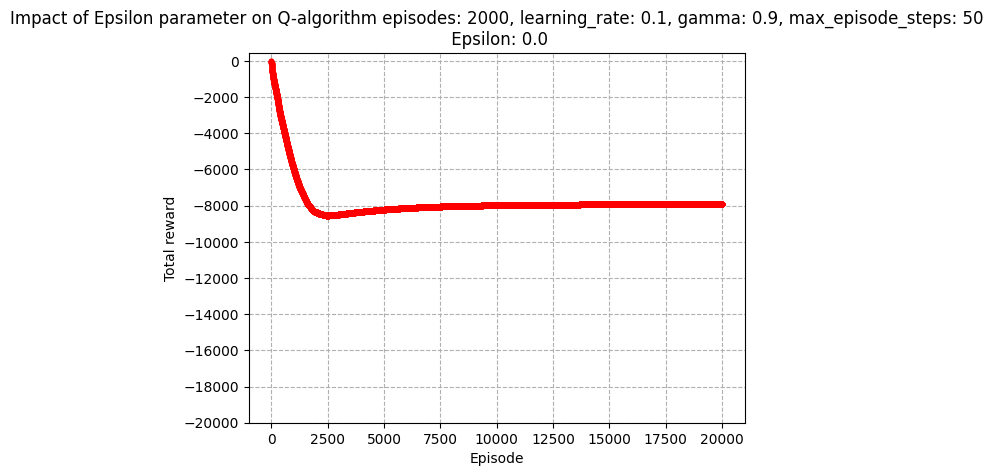

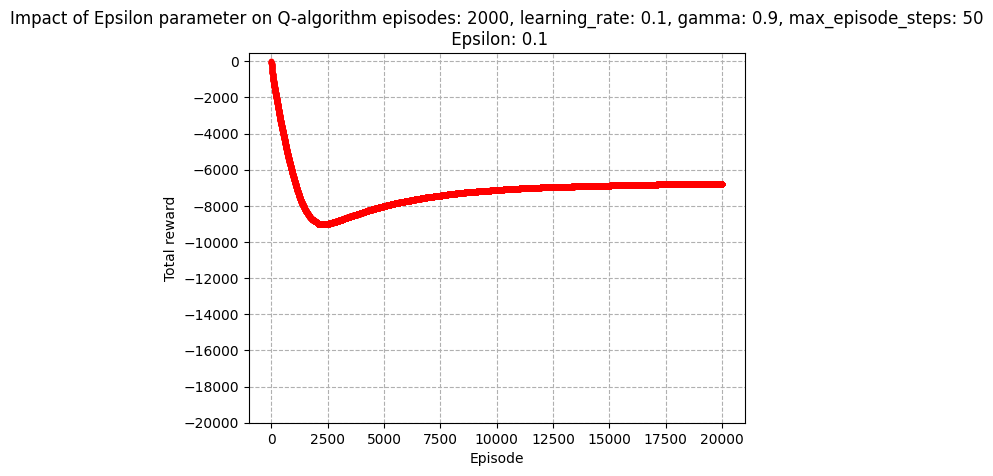

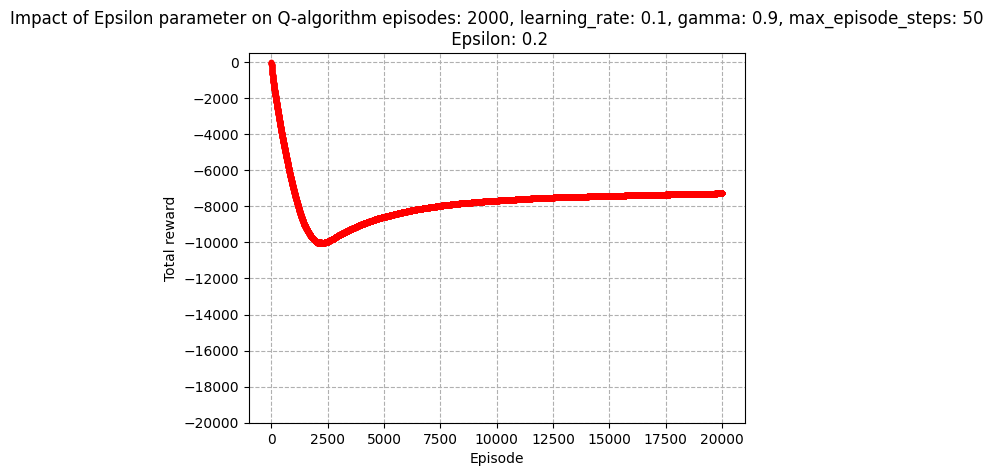

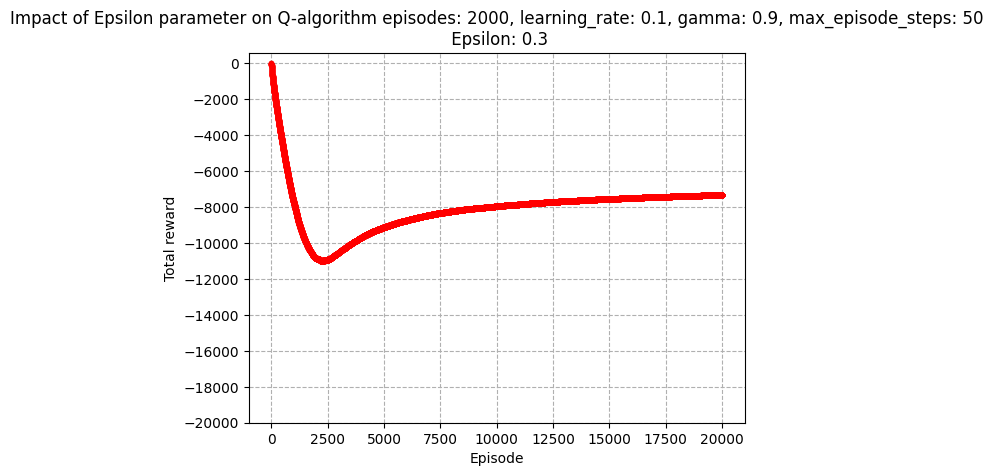

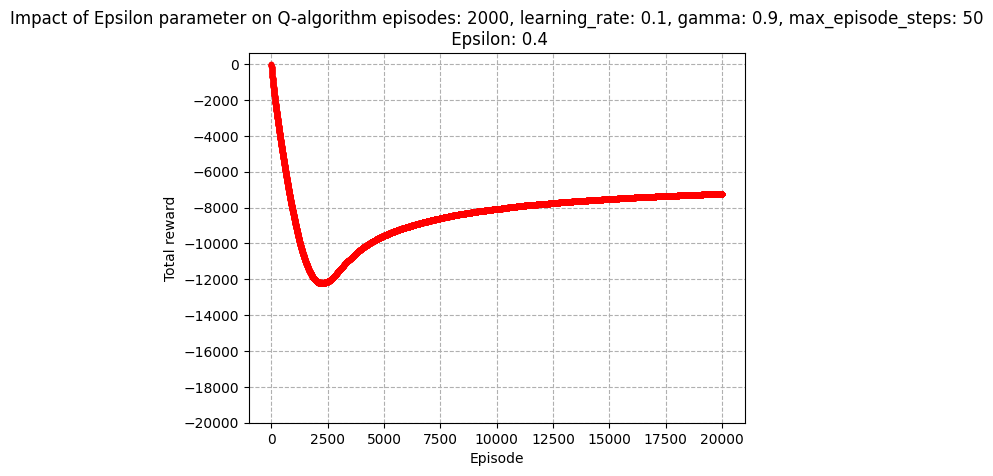

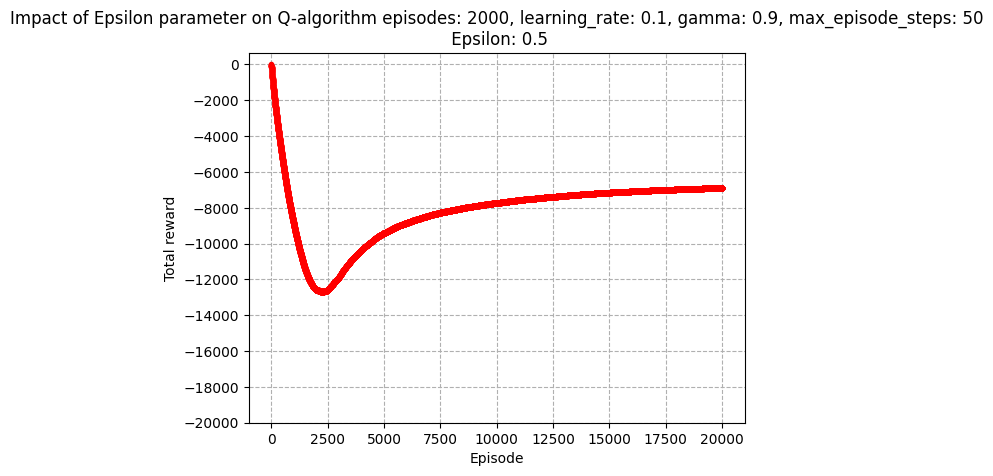

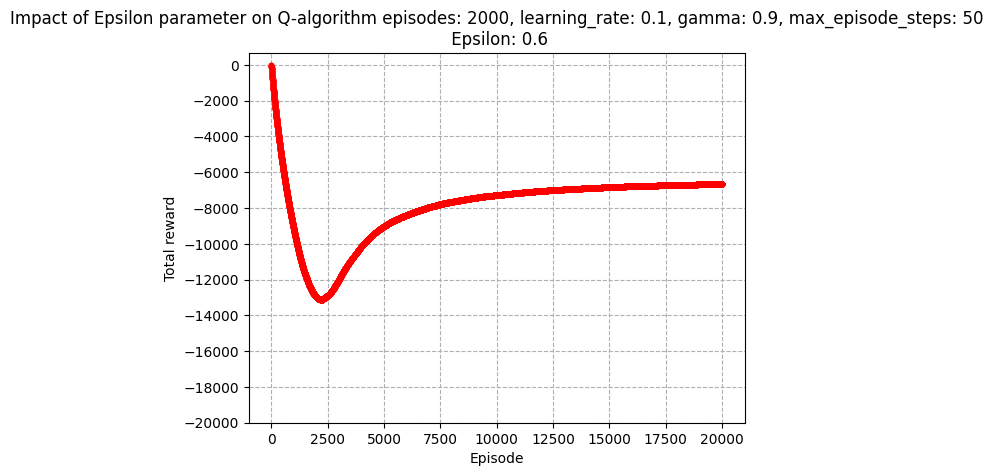

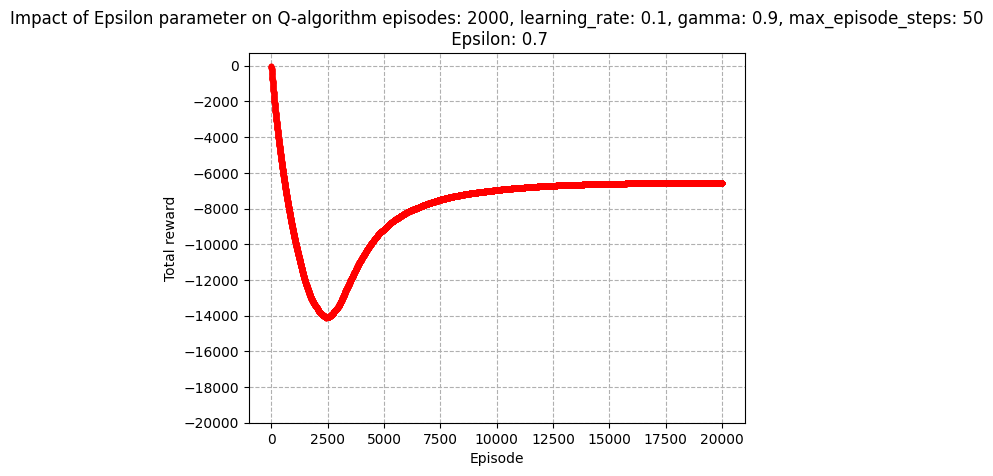

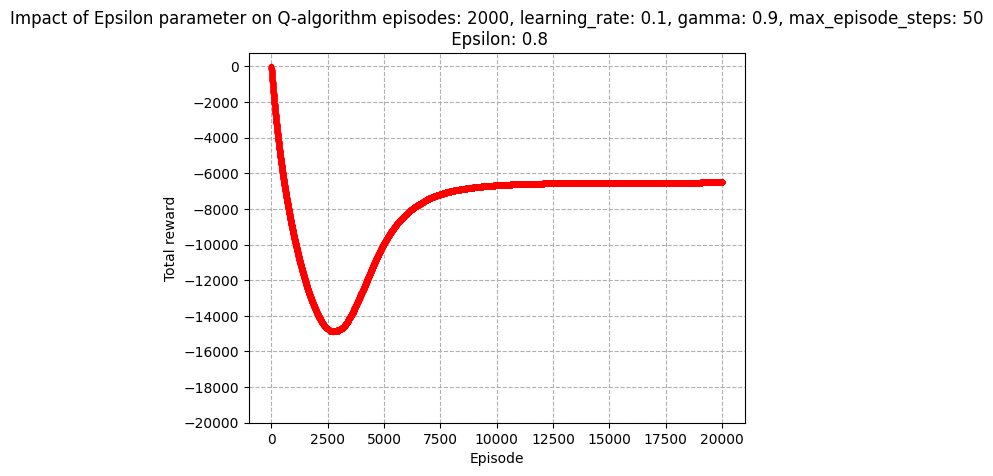

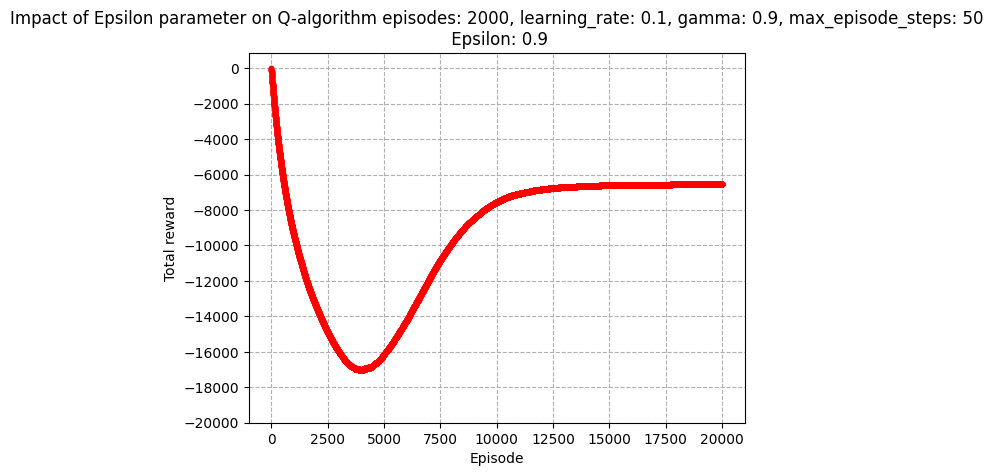

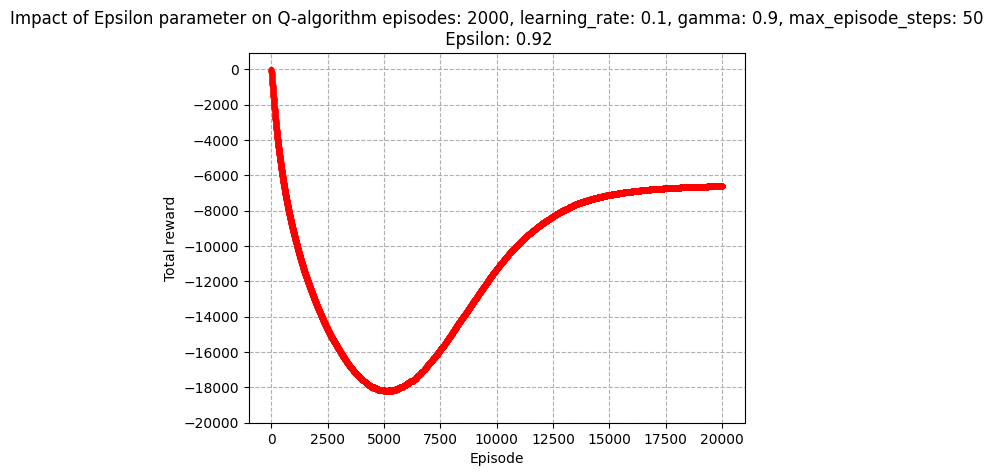

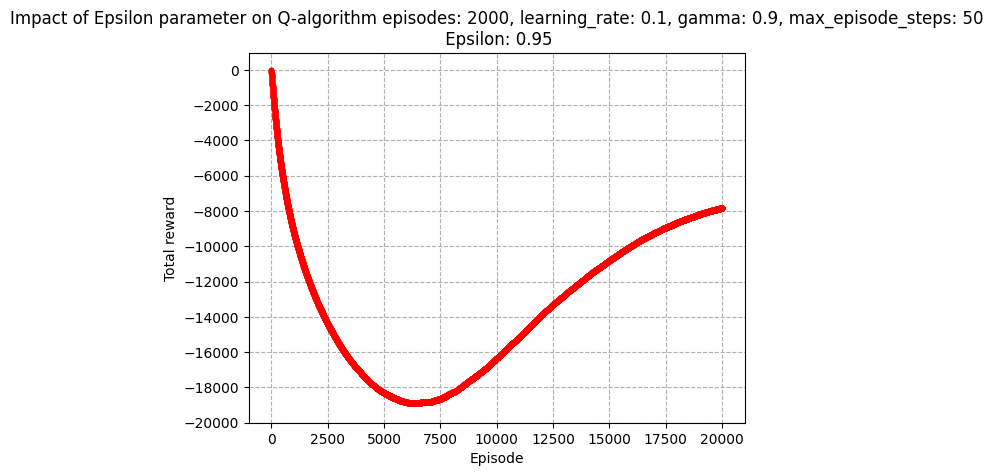

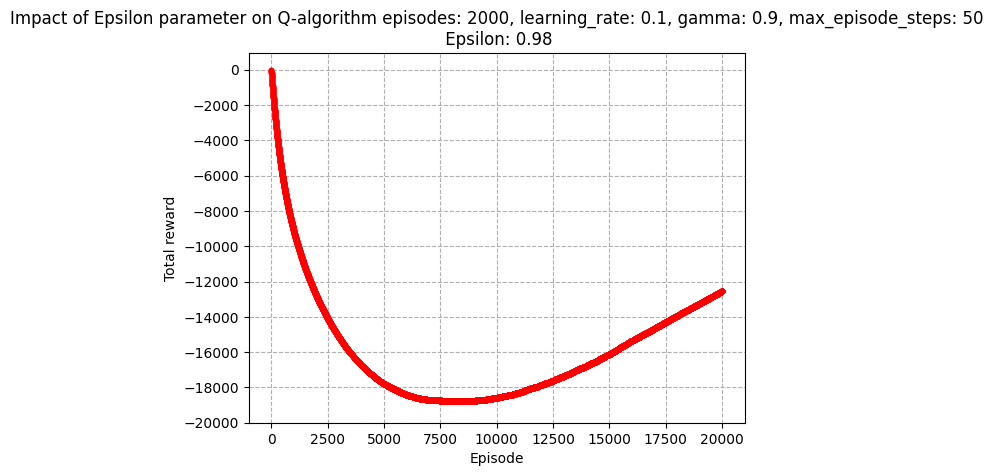

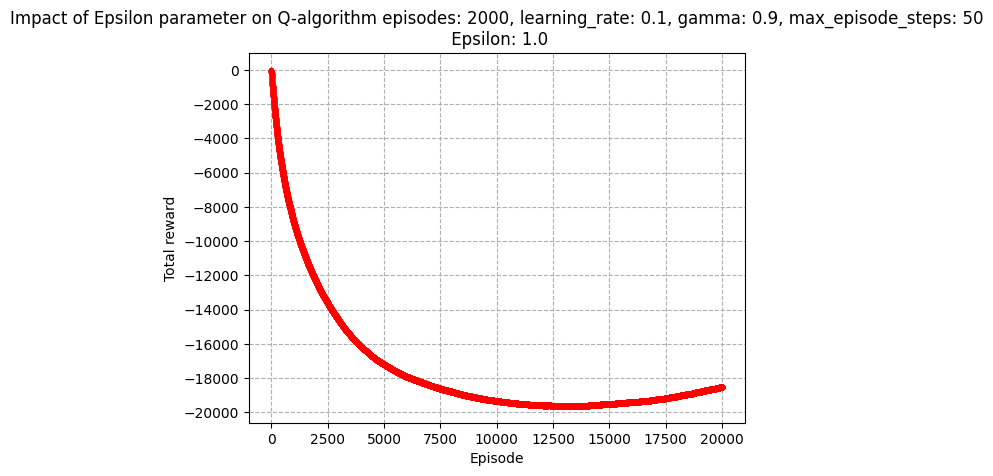

In [53]:
param_values = np.concatenate((np.arange(0, 0.9, 0.1), np.arange(0.9, 1.01, 0.025)))
results = test_hiperparameter(param_name="epsilon", param_values=param_values, episodes = 20000, additional_param_name='learning_rate', additional_param_value=0.1)
keys = results.keys()
trace_rewards = [value[1] for value in results.values()]
for param_value, trace in zip(param_values, trace_rewards):
    plt.plot(range(len(trace)), trace, marker='.', color='r')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.yticks(ticks=np.arange(0, -20000.01, -2000))
    plt.grid(True, linestyle='dashed', zorder=2.5)
    plt.title(f'Impact of Epsilon parameter on Q-algorithm episodes: 2000, learning_rate: 0.1, gamma: 0.9, max_episode_steps: 50\n Epsilon: {round(param_value, 2)}')
    plt.show()

- Epsilon odpowiada za prawdopodobieństwo podjęcia losowej decyzji przez agenta zamiast wyboru najlepszej na podstawie q_table
- Im większy epsilon tym większa eksploracja
- Przy początkowch etapach uczenia się duża wartość epsilona pozytywnie wpływa na ten proces, natomiast gdy agent ma większą wiedzę o środowisku epsilon przeszkadza przy eksploatacji